<a href="https://colab.research.google.com/github/Vivek32singh/Cifar10/blob/main/Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [ ]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
dataset = ImageFolder('./data/cifar10'+'/train', transform=ToTensor())

In [ ]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Label: bird


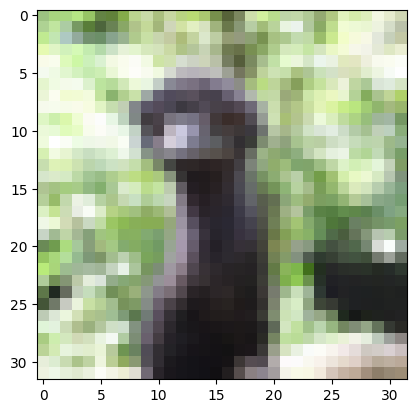

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
image, label = dataset[10009]
plt.imshow(image.permute(1, 2, 0))
print('Label:', dataset.classes[label])

In [ ]:
dataset[0]

(tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
          [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
          [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
          ...,
          [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
          [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
          [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],
 
         [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
          [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
          [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
          ...,
          [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
          [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
          [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],
 
         [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
          [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
          [0.8118, 0.8157, 0.8235,  ...,

In [ ]:
len(dataset)

50000

In [ ]:
val_size=10000
train_size=len(dataset)-val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

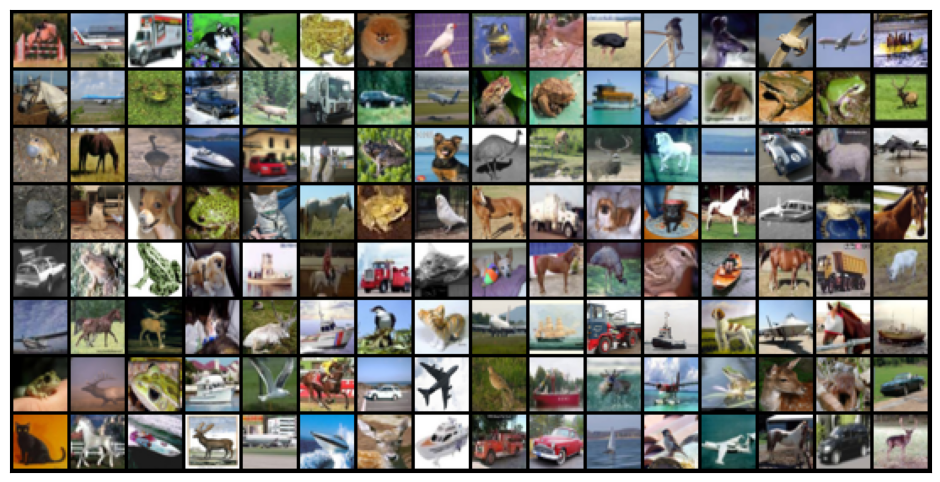

In [ ]:
show_batch(train_dl)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
to_device(model, device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(Cifar10CnnModel(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.302919626235962, 'val_acc': 0.10136719048023224}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.8224, val_loss: 1.5103, val_acc: 0.4325
Epoch [1], train_loss: 1.3112, val_loss: 1.1313, val_acc: 0.5877
Epoch [2], train_loss: 1.0360, val_loss: 0.9600, val_acc: 0.6572
Epoch [3], train_loss: 0.8561, val_loss: 0.8403, val_acc: 0.7062
Epoch [4], train_loss: 0.7301, val_loss: 0.7677, val_acc: 0.7322
Epoch [5], train_loss: 0.6135, val_loss: 0.7382, val_acc: 0.7458
Epoch [6], train_loss: 0.5201, val_loss: 0.7201, val_acc: 0.7539
Epoch [7], train_loss: 0.4418, val_loss: 0.7123, val_acc: 0.7721
Epoch [8], train_loss: 0.3613, val_loss: 0.7744, val_acc: 0.7580
Epoch [9], train_loss: 0.2971, val_loss: 0.7867, val_acc: 0.7727


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

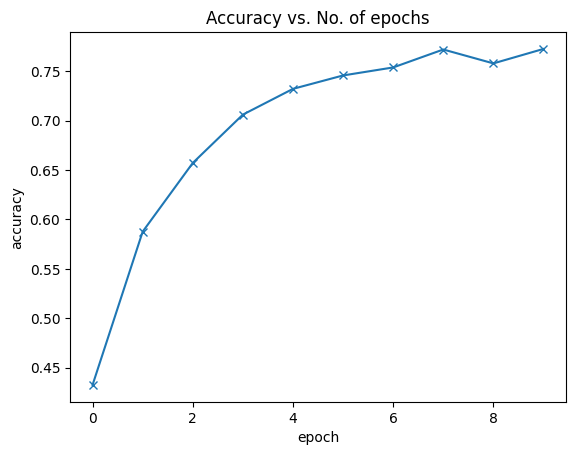

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

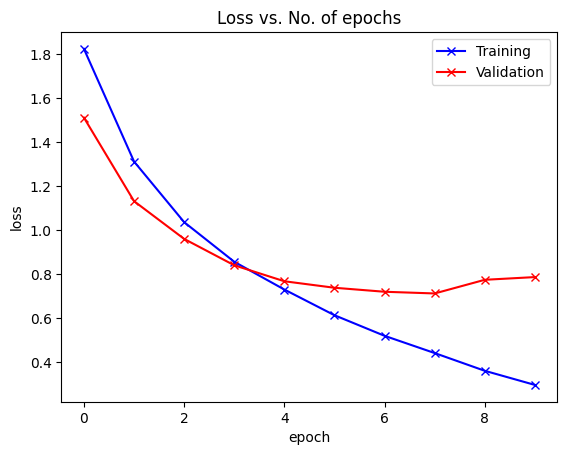

In [ ]:
plot_losses(history)

In [ ]:
test_dataset = ImageFolder('./data/cifar10'+'/test', transform=ToTensor())

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]
    #as we are batch size 1 that why we are using pred[0]

Label: airplane , Predicted: airplane


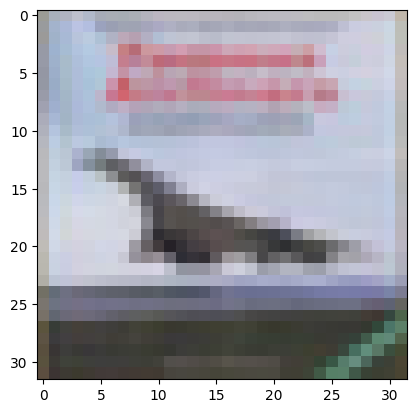

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)

In [ ]:
result = evaluate(model, test_loader)

In [ ]:
result

{'val_loss': 0.8035022020339966, 'val_acc': 0.772753894329071}

In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [ ]:
model2 = to_device(Cifar10CnnModel(), device)

In [ ]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [ ]:
evaluate(model2, test_loader)

{'val_loss': 0.8035022020339966, 'val_acc': 0.772753894329071}